In [148]:
#@title Net structure

import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import cProfile as profile
import string



class NetStructure:
    def __init__(self, input_dim, output_dim):
        self.input_dim  = input_dim
        self.n_hidden   = 0
        self.hidden_dim = []
        self.output_dim = output_dim
        self.activation = []

    def add_hidden(self, hidden_dim, activation = 'linear'):
        self.n_hidden += 1
        self.hidden_dim.append(hidden_dim)
        self.activation.append(activation)

    def get_input_dim(self):
        return self.input_dim

    def get_output_dim(self):
        return self.output_dim

    def get_num_hidden(self):
        return self.n_hidden

    def get_hidden_dim(self, index):
        return self.hidden_dim[index]

    def get_activation(self, index):
        return self.activation[index]

    def print(self):
        print("----------------------")
        print("    Input dim:", self.input_dim)
        for i in range(self.n_hidden):
            print(" Hidden", i+1, "dim:", self.hidden_dim[i], "- activation:", self.activation[i])
        print("   Output dim:", self.output_dim)
        print("----------------------")


In [166]:
#@title Meta

class Meta:
    def __init__(self, net_structure):
        self.net_structure  = net_structure

        # definisco il modello sulla base della struttura che gli ho passato
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(net_structure.get_hidden_dim(0), activation=net_structure.get_activation(0), input_dim=net_structure.get_input_dim()))
        for i in range(1, net_structure.get_num_hidden()):
            self.model.add(tf.keras.layers.Dense(net_structure.get_hidden_dim(i), activation=net_structure.get_activation(i)))
        self.model.add(tf.keras.layers.Dense(net_structure.get_output_dim()))

        # salvo il numero di parametri del modello
        self.num_parameters = self.model.count_params()

        # dominio di default per i latent points
        self.domain = [-1, 1]

        self.output_dim = net_structure.get_output_dim()

    def get_model(self):
        return self.model

    def get_output_dim(self):
        return self.output_dim

    def set_num_iterations(self, num_iterations):
        self.num_iterations = num_iterations

    def set_population_size(self, population_size):
        self.population_size = population_size

    def set_latent_points_domain(self, domain):
        self.domain = domain

    def is_in_domain(self, x):
        if (x < self.domain[0] or x > self.domain[1]):
            return False
        return True

    def generate_latent_points(self, n_samples):
        self.latent_points = np.random.uniform(self.domain[0], self.domain[1], (n_samples, self.net_structure.get_input_dim()))

    def update_model_with_parameters(self, opt_par):
        nl = len(self.model.layers)
        wbindex = 0
        for p in range(0, nl):
          W = opt_par[wbindex:(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1])]
          b = opt_par[(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1]):(wbindex + self.model.layers[p].count_params())]
          self.model.layers[p].set_weights([W.reshape(self.model.layers[p].input.shape[1], self.model.layers[p].output.shape[1]), b])
          wbindex = (wbindex + self.model.layers[p].count_params())

    def objective_function(self, x=None):
        if x is None:
            x = self.latent_points

        y_pred = np.floor(self.model.predict(x, verbose=0))
        somma1 = 0
        somma2 = 0
        
        # Penalize values outside the range [0, 3]: it generates a new array that only includes the elements of 
        # y_pred that are less than 0 or greater than or equal to 3.
        y_pred_outofrange1 = y_pred[(y_pred < 0) | (y_pred > 3)]
        if (len(y_pred_outofrange1)) != 0:
            somma1 = np.exp(np.max(abs(y_pred_outofrange1)))
            
        
        # Penalize unacceptable values for the first two elements: it generates a new array that only includes the elements of 
        # y_pred that are less than 1 or greater than 2.
        y_pred_outofrange2 = y_pred[(y_pred[:, 0] < 1) | (y_pred[:, 0] > 2) | (y_pred[:, 1] < 1) | (y_pred[:, 1] > 2)]
        if (len(y_pred_outofrange2) != 0):
            somma2 = np.exp(np.max(abs(y_pred_outofrange2)))

        # Penalize identical sequences
        y_pred_string = [''.join(map(str, seq)) for seq in y_pred]
        somma3 = (len(y_pred) - len(set(y_pred_string)))

        # Penalize unordered sequences
        somma4 = (np.sum(np.any(y_pred[:, -3:] < y_pred[:, -4:-1], axis=1) ))

        #penalize if the third element is not 1 or 0
        somma5 = np.sum((y_pred[:, 2] != 0) & (y_pred[:, 2] != 1))

       
        print("somma1: ", somma1)
        print("somma2: ", somma2)   
        print("somma4: ", somma4)
        print("somma5: ", somma5)

        return somma1 + somma2 + somma4 + somma3 + somma5

In [150]:
class PSO(Meta):
    def __init__(self, net_structure):
        super().__init__(net_structure)
        self.w  = 0.3 # inertia_param
        self.c1 = 1.5 # cognitive_param
        self.c2 = 1.5 # social_param

    def set_options(self, inertia_param = 0.3,
                    cognitive_param = 1.5,
                    social_param = 1.5):
        self.w  = inertia_param
        self.c1 = cognitive_param
        self.c2 = social_param

    def set_max_v(self, max_v):
        self.max_v = max_v

    def set_max_x(self, max_x):
        self.max_x = max_x

    def update_velocity(self, position, velocity, best_position, global_best_position):
        inertia = self.w * velocity
        cognitive_component = self.c1 * np.random.rand(1, len(position)) * (best_position - position)
        social_component = self.c2 * np.random.rand(1, len(position)) * (global_best_position - position)
        new_velocity = inertia + cognitive_component + social_component
        return new_velocity

    def optimize(self):
        # ATTENZIONE: è necessario aver generato i latent points in precedenza
        particles  = np.random.uniform(low=0, high=self.max_x, size=(self.population_size, self.num_parameters))
        velocities = np.random.uniform(low=-self.max_v, high=self.max_v, size=(self.population_size, self.num_parameters))
        best_positions = np.copy(particles)
        best_scores = np.array([self.num_parameters] * self.population_size)
        global_best_position = None
        global_best_score = 1e10
        nl = len(self.model.layers)

        for iteration in range(self.num_iterations):
            tic_global = time.perf_counter()

            for i in range(self.population_size):
                particle = particles[i,]

                wbindex = 0

                for p in range(0, nl):
                  W = particle[wbindex:(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1])]
                  b = particle[(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1]):(wbindex + self.model.layers[p].count_params())]
                  self.model.layers[p].set_weights([W.reshape(self.model.layers[p].input.shape[1], self.model.layers[p].output.shape[1]), b])
                  wbindex = (wbindex + self.model.layers[p].count_params())

                fitness = self.objective_function()

                # print(fitness)

                if  fitness < best_scores[i]:
                    best_scores[i] = fitness
                    best_positions[i] = np.copy(particles[i])

                if  fitness < global_best_score:
                    global_best_score = fitness
                    global_best_position = np.copy(particles[i])

                velocities[i] = self.update_velocity(particles[i], velocities[i], best_positions[i], global_best_position)
                particles[i] += velocities[i]

            # mi assicuro che le velocità e posizioni siano nei range
            velocities = np.minimum(velocities,  self.max_v)
            velocities = np.maximum(velocities, -self.max_v)
            particles  = np.minimum(particles,  self.max_x)
            particles  = np.maximum(particles, -self.max_x)

            toc_global = time.perf_counter()
            print("Iteration #%d - Objective function value: %5.2f - time: %0.3f" % (iteration, global_best_score, toc_global - tic_global))

            # se l'errore fa a zero mi fermo
            if (global_best_score == 0):
                break

        return global_best_position

    def predict(self, x = None):
        if (x == None):
            x = self.latent_points
        return self.model.predict(x)


########################################################################
########################################################################
########################################################################

## Code for generating a couple of numbers (a,b) where a > b

net = NetStructure(input_dim=2, output_dim=5)
net.add_hidden(hidden_dim=5)

met = PSO(net)
met.set_num_iterations(70)
met.set_population_size(40)
met.set_max_v(0.3)
met.set_max_x(1.5)

sample_size = 1000
domain = [0, 1]

# TRAIN
met.set_latent_points_domain(domain)               # definisco il dominio per i latent points
met.generate_latent_points(sample_size)            # genera i latent points su cui fare il training
optimized_params = met.optimize()                  # trova i parametri migliori della rete
met.update_model_with_parameters(optimized_params) # setta nella rete i parametri migliori



somma1:  22026.467
somma2:  44052.93359375
somma4:  3000
somma1:  8103.084
somma2:  16206.16796875
somma4:  3000
somma1:  442413.38
somma2:  884826.75
somma4:  3000
somma1:  8103.084
somma2:  16206.16796875
somma4:  3000
somma1:  162754.78
somma2:  325509.5625
somma4:  2835
somma1:  59874.14
somma2:  119748.28125
somma4:  3000
somma1:  8103.084
somma2:  16206.16796875
somma4:  3000
somma1:  22026.467
somma2:  44052.93359375
somma4:  3000
somma1:  442413.38
somma2:  884826.75
somma4:  3000
somma1:  162754.78
somma2:  325509.5625
somma4:  3000
somma1:  8103.084
somma2:  16206.16796875
somma4:  3000
somma1:  59874.14
somma2:  119748.28125
somma4:  3000
somma1:  2980.958
somma2:  5961.916015625
somma4:  3000
somma1:  59874.14
somma2:  119748.28125
somma4:  3000
somma1:  162754.78
somma2:  325509.5625
somma4:  285
somma1:  8103.084
somma2:  16206.16796875
somma4:  3000
somma1:  8103.084
somma2:  16206.16796875
somma4:  3000
somma1:  162754.78
somma2:  325509.5625
somma4:  3000
somma1:  8103

KeyboardInterrupt: 

In [ ]:
# TEST
met.generate_latent_points(sample_size) # genera nuovi latent points su cui fare la predizione
y_test = met.predict()                  # fa la predizione sui latent points
l_test = met.objective_function()       # calcola la loss sui latent points

# print("\nObjective function value: (test data): " , l_test)
print(np.floor(y_test[0,:]))
print("\nAccuracy (test data): " , (sample_size - l_test)/sample_size * 100, "%")
print(np.floor(y_test[:20 , :]))

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
somma1:  148.41316
somma2:  296.8263244628906
somma4:  96
somma5:  610
[1. 2. 2. 2. 2.]

Accuracy (test data):  -111.0239486694336 %
[[ 1.  2.  2.  2.  2.]
 [ 3.  4.  4.  4.  4.]
 [ 3.  5.  4.  5.  5.]
 [ 1.  1.  1.  2.  2.]
 [ 0.  1.  1.  1.  2.]
 [ 0.  0.  1.  1.  1.]
 [-1.  0.  0.  1.  1.]
 [ 0.  1.  1.  2.  2.]
 [ 1.  2.  2.  2.  2.]
 [ 1.  2.  2.  2.  2.]
 [ 0.  1.  1.  2.  2.]
 [ 1.  1.  2.  2.  3.]
 [ 2.  2.  3.  3.  3.]
 [ 2.  3.  3.  3.  3.]
 [ 1.  2.  2.  2.  3.]
 [ 2.  3.  3.  3.  3.]
 [ 1.  2.  2.  2.  2.]
 [ 0.  1.  1.  2.  2.]
 [ 1.  2.  3.  3.  3.]
 [ 2.  2.  3.  3.  3.]]


set()


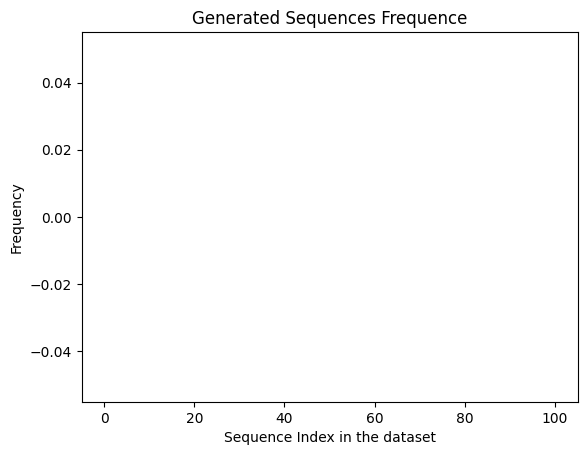

In [ ]:
class Sequence:
    def __init__(self, data: list) -> None:
        data = [int(x) for x in data]
        self.data = data

    def __eq__(self, rhs) -> bool:
        return self.data == rhs.data

# Mount Google Drive if your file is saved there
#from google.colab import drive
#drive.mount('/content/drive')

# File path to your text file
file_path = "/workspaces/Works/v_operations_2.txt"

# Read the text file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the text into a vector of Sequence
vect_seq = []
for line in lines:
    row = [int(x) for x in line.split()]
    seq = Sequence(row)
    vect_seq.append(seq)
  
plt.figure()
freq = []

for i in range(0, len(y_test)):
    seq = Sequence(np.floor(y_test[i,:]))
    if seq in vect_seq:
        freq.append(vect_seq.index(seq))

plt.hist(freq, bins=100, color='blue', range = [0, 100])
#plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Sequence Index in the dataset")
plt.title('Generated Sequences Frequence')
print(set(freq))
plt.show(block=False)



In [167]:
#@title Class GA

class GA(Meta):

    def __init__(self, net_structure):
        super().__init__(net_structure)
        self.x_rate = 0.60
        self.number_of_crossover = 3
        self.mutation_rate = 0.1

    def set_options(self, x_rate = 0.60, number_of_crossover = 3, mutation_rate = 0.1):
        self.x_rate = x_rate
        self.number_of_crossover = number_of_crossover
        self.mutation_rate = mutation_rate

    def set_max_x(self, max_x):
        self.max_x = max_x

    def selection_function(self, population, costs):
    #trasformo la percentuale di x_rate in un valore numerico che indica fino a che inidirizzo del vettore population devo arrivare
        n = int(self.x_rate * self.population_size)
        costs = costs[:len(population)]
        indices = np.argsort(costs)
    #ordino con la funzione sorted i valori della funzione di costo corrispondenti ad ogni genoma e ne cosnidero solo alcuni (x_rate)
        sorted_population = population[indices]
        selected_population = sorted_population[:n]
        return selected_population

    #mating functions: uniform crossover(random), Roulette Wheel weighting (utilizzando i cost), Tournament selection, blending method (Haupt)
    def roulette_wheel_weighting(self, population, costs):
        probability = []
        costs =  np.sort(costs)
        ordinated_costs = costs[:len(population)]
        cost_n = costs[len(population)]
        for i in range(len(population)):
    # normalizzo i valori della funzione di costo affinchè la somma sia uno
            probability.append((ordinated_costs[i] - cost_n) / (sum(ordinated_costs) - (cost_n * len(ordinated_costs))))
        rand = np.random.uniform(probability[-1], 1)
    # trovo il cromosoma che corrisponde all'intervallo in cui cade rand
        for q in range(len(probability)):
            if rand > probability[q]:
                chosen_chromosome =  population[q]
                return chosen_chromosome


    def mating(self, population, costs):
        for i in range(self.number_of_crossover):
            father = self.roulette_wheel_weighting(population, costs)
            mother = self.roulette_wheel_weighting(population, costs)
            beta = np.random.uniform(low = 0, high = 10, size = (self.num_parameters))
            #crossover: blending method
            offspring_1 = father - np.multiply(beta, mother - father)
            offspring_2 = mother + np.multiply(beta, mother - father)

            population = np.vstack((population, offspring_1))
            population = np.vstack((population, offspring_2))
        return population

    def mutation(self, population, best_index):
    # numero di mutazioni che bisogna eseguire
        mutation_number = int(self.mutation_rate * self.num_parameters * len(population))
    # ripeto mutation_number volte: prendo un cromosoma qualsiasi e di questo modifico un gene qualsiasi
        for t in range(mutation_number):
            chromosome_choice = np.random.randint(0, len(population)-1)
            if t == chromosome_choice and best_index != t:
                for p in range(len(population)):
                    gene_choice = np.random.randint(0, self.num_parameters-1)
                    if p == gene_choice:
                        population[t][gene_choice] = np.random.uniform(low = -self.max_x, high = self.max_x)
        return population


    def optimize(self):
        population = np.random.uniform(low = -self.max_x, high = self.max_x, size = (self.population_size, self.num_parameters ))
        best_positions = np.copy(population)
        best_scores = np.array([self.num_parameters] * self.population_size)
        global_best_position = np.copy(population[0])
        global_best_score = 1e10
        nl = len(self.model.layers)
        costs = np.zeros(self.population_size)
        len_population = len(population)

        for iteration in range(self.num_iterations):
            tic_global = time.perf_counter()

            for i in range(len_population):
                genome = population[i,]
                best_index = 0

                wbindex = 0

                for p in range(0, nl): #Generazione della rete
                  W = genome[wbindex:(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1])]
                  b = genome[(wbindex + self.model.layers[p].input.shape[1] * self.model.layers[p].output.shape[1]):(wbindex + self.model.layers[p].count_params())]
                  self.model.layers[p].set_weights([W.reshape(self.model.layers[p].input.shape[1], self.model.layers[p].output.shape[1]), b])
                  wbindex = (wbindex + self.model.layers[p].count_params())


                fitness = self.objective_function()
                costs[i] = self.objective_function()


                #print(fitness)

                if  fitness < best_scores[i]:
                    best_scores[i] = fitness
                    best_positions[i] = np.copy(population[i])

                if  fitness < global_best_score:
                    global_best_score = fitness
                    best_index = i
                    global_best_position = np.copy(population[i])


            population = self.selection_function(population, costs)
            population = self.mating(population, costs)
            population = self.mutation(population, best_index)

            toc_global = time.perf_counter()
            len_population = len(population)


            population  = np.minimum(population,  self.max_x)
            population  = np.maximum(population, -self.max_x)


            print("Iteration #%d - Objective function value: %5.2f - time: %0.3f - local best score: %5.2f" % (iteration, global_best_score, toc_global - tic_global ,  best_scores[0]))
            if (global_best_score == 0):
                break


        return global_best_position

    def predict(self, x = None):
        if (x == None):
            x = self.latent_points
        return self.model.predict(x)

In [171]:
net = NetStructure(input_dim=2, output_dim=5)
net.add_hidden(hidden_dim=5)

met = GA(net)
met.set_num_iterations(30)
met.set_population_size(70)
met.set_max_x(1.5)


sample_size = 1000
domain = [-1, 1]

# TRAIN
met.set_latent_points_domain(domain)               # definisco il dominio per i latent points
met.generate_latent_points(sample_size)            # genera i latent points su cui fare il training
optimized_params = met.optimize()                  # trova i parametri migliori della rete
met.update_model_with_parameters(optimized_params) # setta nella rete i parametri migliori

somma1:  403.42877
somma2:  403.42877
somma4:  1000
somma5:  673
somma1:  403.42877
somma2:  403.42877
somma4:  1000
somma5:  673
somma1:  403.42877
somma2:  403.42877
somma4:  995
somma5:  861
somma1:  403.42877
somma2:  403.42877
somma4:  995
somma5:  861
somma1:  403.42877
somma2:  403.42877
somma4:  589
somma5:  704
somma1:  403.42877
somma2:  403.42877
somma4:  589
somma5:  704
somma1:  54.59815
somma2:  54.59815
somma4:  1000
somma5:  831
somma1:  54.59815
somma2:  54.59815
somma4:  1000
somma5:  831
somma1:  54.59815
somma2:  54.59815
somma4:  1000
somma5:  606
somma1:  54.59815
somma2:  54.59815
somma4:  1000
somma5:  606
somma1:  148.41316
somma2:  148.41316
somma4:  863
somma5:  673
somma1:  148.41316
somma2:  148.41316
somma4:  863
somma5:  673
somma1:  1096.6332
somma2:  1096.6332
somma4:  980
somma5:  538
somma1:  1096.6332
somma2:  1096.6332
somma4:  980
somma5:  538
somma1:  148.41316
somma2:  148.41316
somma4:  1000
somma5:  371
somma1:  148.41316
somma2:  148.41316
som

/tmp/ipykernel_1475/1261750990.py:37: RuntimeWarning: invalid value encountered in scalar divide
  probability.append((ordinated_costs[i] - cost_n) / (sum(ordinated_costs) - (cost_n * len(ordinated_costs))))


OverflowError: Range exceeds valid bounds

In [ ]:
# TEST
met.generate_latent_points(sample_size) # genera nuovi latent points su cui fare la predizione
y_test = met.predict()                  # fa la predizione sui latent points
l_test = met.objective_function()       # calcola la loss sui latent points

# print("\nObjective function value: (test data): " , l_test)
print(np.floor(y_test[0,:]))
print("\nAccuracy (test data): " , (sample_size - l_test)/sample_size * 100, "%")
print(np.floor(y_test[:20 , :]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


somma1:  54.59815
somma2:  54.59815
somma4:  118
somma5:  1000
[ 1. -4. -3. -2.  2.]

Accuracy (test data):  -120.91962966918945 %
[[ 1. -4. -3. -2.  2.]
 [ 1. -1. -1.  0.  1.]
 [ 1. -3. -3. -1.  2.]
 [ 1. -1. -1.  0.  1.]
 [ 1. -1. -1.  0.  1.]
 [ 1. -3. -3. -1.  2.]
 [ 1. -2. -2.  0.  1.]
 [ 1. -2. -2. -1.  1.]
 [ 1. -4. -3. -1.  2.]
 [ 1. -3. -3. -1.  2.]
 [ 1. -4. -3. -1.  2.]
 [ 1. -1. -2.  0.  1.]
 [ 1. -2. -2.  0.  1.]
 [ 1. -3. -3. -1.  2.]
 [ 1. -4. -3. -1.  2.]
 [ 1. -2. -2. -1.  1.]
 [ 1. -2. -2. -1.  1.]
 [ 1. -4. -3. -1.  2.]
 [ 1. -2. -2.  0.  1.]
 [ 1. -3. -3. -1.  2.]]


set()


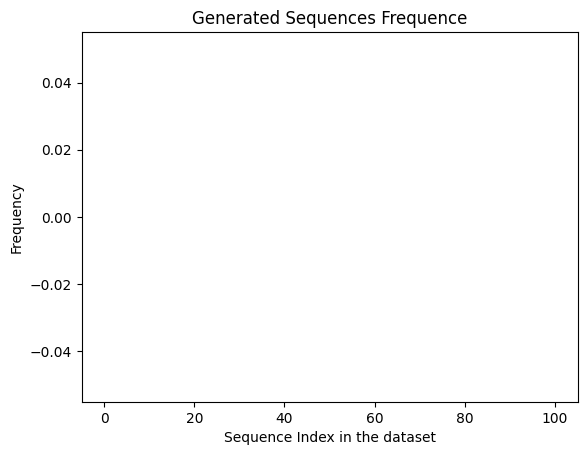

In [ ]:
class Sequence:
    def __init__(self, data: list) -> None:
        data = [int(x) for x in data]
        self.data = data

    def __eq__(self, rhs) -> bool:
        return self.data == rhs.data

# Mount Google Drive if your file is saved there
#from google.colab import drive
#drive.mount('/content/drive')

# File path to your text file
file_path = "/workspaces/Works/v_operations_2.txt"

# Read the text file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the text into a vector of Sequence
vect_seq = []
for line in lines:
    row = [int(x) for x in line.split()]
    seq = Sequence(row)
    vect_seq.append(seq)
  
plt.figure()
freq = []

for i in range(0, len(y_test)):
    seq = Sequence(np.floor(y_test[i,:]))
    if seq in vect_seq:
        freq.append(vect_seq.index(seq))

plt.hist(freq, bins=100, color='blue', range = [0, 100])
#plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Sequence Index in the dataset")
plt.title('Generated Sequences Frequence')
print(set(freq))
plt.show(block=False)

